In [1]:
import qiskit

In [2]:
qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-utokyo')
#provider.backends()
backend = provider.get_backend("ibmq_casablanca")

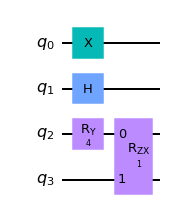

In [17]:
qc = qiskit.QuantumCircuit(4)
qc.x(0)
qc.h(1)
qc.ry(4,2)
qc.rzx(1,2,3)
qc.draw("mpl")

- RZX basis 

In [4]:
qcswap = qiskit.QuantumCircuit(2)
qcrzz= qiskit.QuantumCircuit(2)

from qiskit.transpiler.passes import TemplateOptimization
from qiskit.transpiler import PassManager, passes
# 1. Template substitution: introduces custom # gates with an rzx decomposition
cost_dict = {'sx': 1, 'x': 1, 'rz': 0, 'cx': 10, 'rzx': 2, 'swap': 6}
pass_ = TemplateOptimization(template_list=[qcswap,qcrzz],user_cost_dict=cost_dict)
qct = PassManager(pass_).run(qc)
# 2. Unroll to rzx basis and simplify gates
gates = ['rz', 'sx', 'rzx', 'cx', 'x']
qct_rzx = qiskit.transpile(qct,backend,optimization_level=1,basis_gates=gates, initial_layout=[0,3,1,2])
# 3. Add custom rzx pulse schedules
pass_ = passes.scheduling.calibration_creators.RZXCalibrationBuilderNoEcho(backend)
cal_qc = PassManager(pass_).run(qct_rzx)

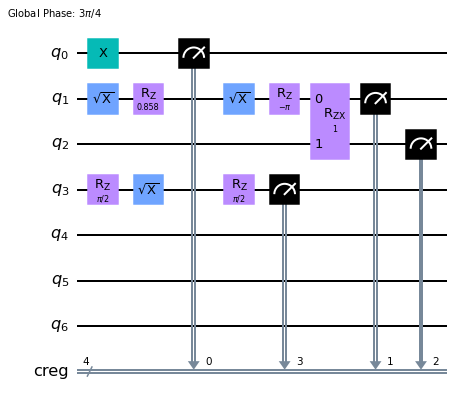

In [5]:
cr = qiskit.ClassicalRegister(4,'creg')
cal_qc.add_register(cr)
cal_qc.measure(0,0)
cal_qc.measure(1,1)
cal_qc.measure(2,2)
cal_qc.measure(3,3)
cal_qc.draw("mpl")

In [6]:
job = qiskit.execute(cal_qc, backend, shots = 8192, optimization_level=0)

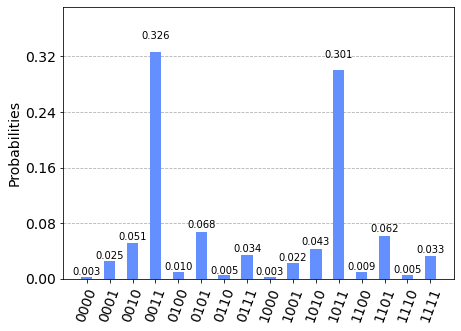

In [7]:
counts_rzx = job.result().get_counts()
qiskit.visualization.plot_histogram(counts_rzx)

- Normal basis

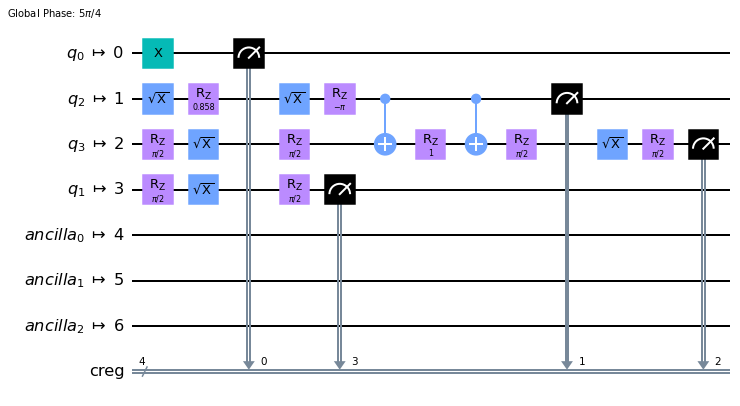

In [8]:
qct_normal = qiskit.transpile(qc,backend,optimization_level=1, initial_layout=[0,3,1,2])
cr = qiskit.ClassicalRegister(4,'creg')
qct_normal.add_register(cr)
qct_normal.measure(0,0)
qct_normal.measure(1,1)
qct_normal.measure(2,2)
qct_normal.measure(3,3)
qct_normal.draw("mpl")

In [9]:
job = qiskit.execute(qct_normal, backend, shots = 8192, optimization_level=0)

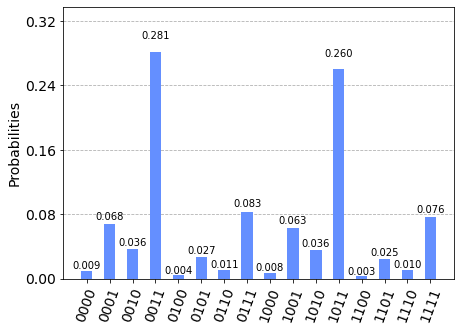

In [10]:
counts_normal = job.result().get_counts()
qiskit.visualization.plot_histogram(counts_normal)

- sim

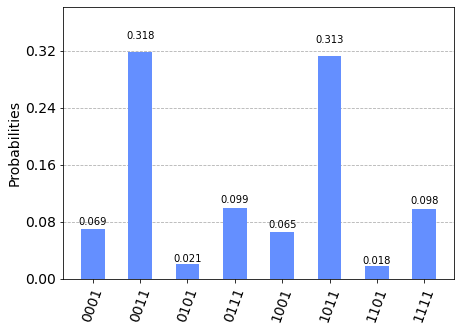

In [32]:
qc_ = qc.copy()
cr = qiskit.ClassicalRegister(4,'creg')
qc_.add_register(cr)
qc_.measure(0,0)
qc_.measure(1,3)
qc_.measure(2,1)
qc_.measure(3,2)
job = qiskit.execute(qc_, qiskit.Aer.get_backend('qasm_simulator'), shots = 8192)
counts_sim = job.result().get_counts()
qiskit.visualization.plot_histogram(counts_sim)

- compare

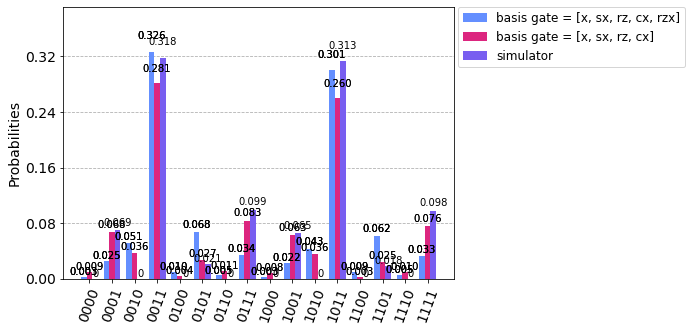

In [34]:
qiskit.visualization.plot_histogram([counts_rzx, counts_normal, counts_sim], legend=['basis gate = [x, sx, rz, cx, rzx]', 'basis gate = [x, sx, rz, cx]', 'simulator'])